# Approximation

There are many cases where we end up with very high order models or models with dead time which we would like to approximate with lower order models or models without dead time. This notebook illustrates some of the approaches.

In [1]:
import sympy
sympy.init_printing()
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tbcontrol

In [3]:
tbcontrol.expectversion('0.1.7')

## Taylor approximation

We have encountered Taylor approximants before. They are polynomial approximations and can easily be calculated using the `sympy.series` function.

In [4]:
x = sympy.symbols('x')

In [5]:
f = sympy.sin(x)

Note that Sympy uses the number of terms instead of the order of the polynomial, so this is a second order polynomial about the point x=2

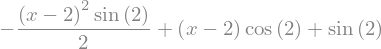

In [6]:
f.series(x, 2, 3).removeO()

Let's plot a couple of approximations of `sin(x)`:

In [7]:
def taylor(xlim, ylim):
    p = sympy.plot(f, (x, *xlim), show=False)
    colors = ['red', 'green', 'magenta', 'brown']
    for n, color in enumerate(colors, 1):
        approx = f.series(x, 2, n).removeO()
        p.extend(sympy.plot(approx, (x, *xlim),
                 line_color=color, show=False))
        p[n].label = f'Order: {n-1}'
    p.ylim = ylim
    p.xlim = xlim
    p.legend = True
    p.show()

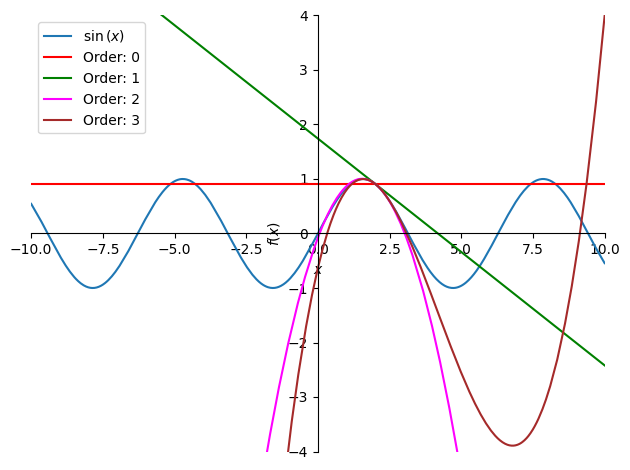

In [8]:
taylor((-10, 10), (-4, 4))

An important characteristic of all polynomial approximations is that the function always grows large "far enough" away from the origin and therefore cannot model asymptotes very well. Let's zoom out on that graph a bit:

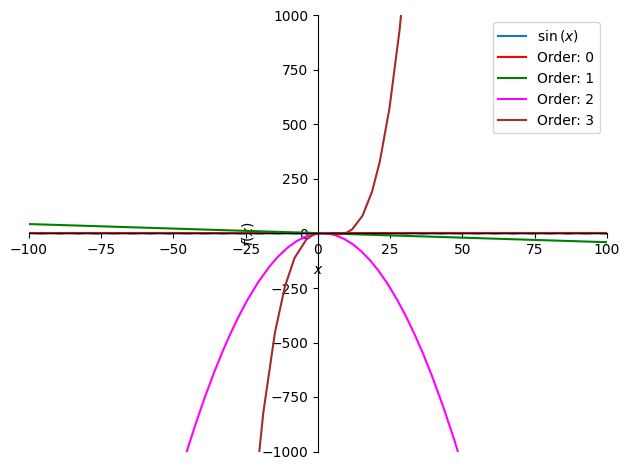

In [9]:
taylor((-100, 100), (-1000, 1000))

## Padé approximation

Padé approximation is an extension of the concept of Taylor approximation with rational functions rather than polynomials. The basic premise is that the approximation is made by matching derivatives at a particular point. Padé approximants are often associated with dead time approximation, but can be used for arbitrary transfer functions as well.

One of the big benefits of Padé approximants is that rational functions can become constant for large magnitudes of $x$.

We will approximate a Laplace dead time

In [10]:
s = sympy.symbols('s')

In [11]:
G = sympy.exp(-2*s)
G

by a 1/1 Padé approximation. This means first order above the line and first order below. In order to force uniqueness of the solution, we force the constant term in the denominator to be unity.

In [12]:
import tbcontrol.symbolic

In [13]:
s0 = 0 

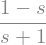

In [14]:
G_pade = tbcontrol.symbolic.pade(G, s, 1, 1, s0)
G_pade

Compare this with a taylor approximation with same number of coefficients (matching the same number of derivatives)

In [15]:
G_taylor = G.series(s, s0, 3).removeO()
G_taylor

So how much do the approximations resemble the original function?

First, let's check just the real part

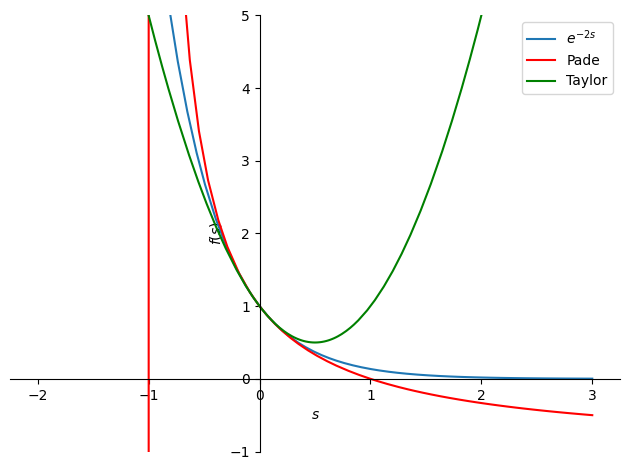

In [16]:
plotrange = (s, -2, 3)
def plot_approx(G, G_pade, G_taylor):
    p = sympy.plot(G, plotrange, show=False)
    pade_approx = sympy.plot(G_pade, plotrange, show=False, line_color='red')
    taylor_approx = sympy.plot(G_taylor, plotrange, show=False, line_color='green')
    p.extend(pade_approx)
    p.extend(taylor_approx)
    p[1].label = 'Pade'
    p[2].label = 'Taylor'
    p.ylim = (-1, 5)
    p.legend = True
    p.show()
plot_approx(G, G_pade, G_taylor)

Note the singularity in the Padé approximation, as well as the fact that the Taylor polynomial has an unbounded error to the right, while the Padé approximation is better behaved.

Now, let's see what this looks like for the whole complex plane

In [17]:
try:
    import mpmath
except ImportError:
    from sympy import mpmath

In [18]:
def cplot(G):
    f = sympy.lambdify(s, G, ['mpmath', 'numpy'])
    mpmath.cplot(f, [-2, 2], [-2, 2], points=10000)

The original function

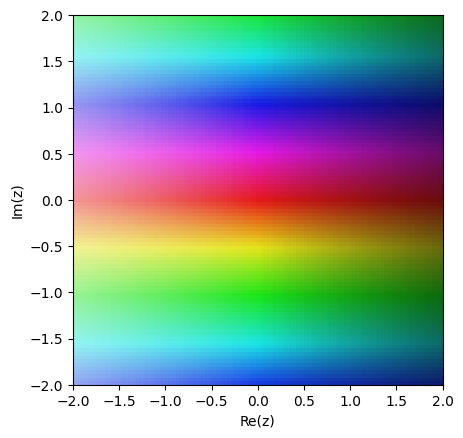

In [19]:
cplot(G)

Pade approximation

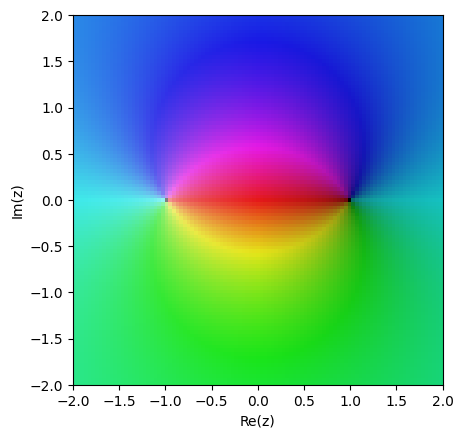

In [20]:
cplot(G_pade)

Taylor approximation

In [21]:
cplot(G_taylor)

The Pade approximation is much better in the region around 0.

### Further exploration

Padé approximations with order 0 below the line are effectively Taylor polynomials

In [ ]:
tbcontrol.symbolic.pade(G, s, 1, 0, 0)

This form is often used the other way around to approximate lags with dead time

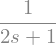

In [ ]:
tbcontrol.symbolic.pade(G, s, 0, 1, 0)

In [ ]:
def approx_comparison(G, M, N):
    P = tbcontrol.symbolic.pade(G, s, M, N, 0)
    T = sympy.series(G, s, 0, N+M+1).removeO()
    plot_approx(G, P, T)


In [ ]:
from ipywidgets import interact

In [ ]:
deadtime = sympy.exp(-2*s)
high_order = 1/(s + 1)**10

In [ ]:
plotrange=(s, -5, 5)

In [ ]:
interact(approx_comparison, G=[deadtime, high_order], N=(0, 3), M=(1, 3))

## Approximations based on response matching

The approximations we discussed above are based on matching the values in the Laplace domain. However, we often want to find an approximation which has the property of matching the time domain responses.

A common-sense rule is that larger time constants are more important to retain than smaller ones. My personal rule is that any time constant which is less than 10 times smaller than the next largest one can usualy be ignored, in other words, for our purposes

$$ \frac{1}{(10s + 1)(s + 1)} \approx \frac{1}{10s + 1}$$

**Note 1** It is conventional to arrange the terms in descending orders of time constants.

**Note 2** This is a rule of thumb and should not be applied during intermediate calculations. You should always be aware of the point where you are applying approximation and make a note that you have done this.

In this section I'll be using the [Python Control Systems Library](https://python-control.readthedocs.io/en/latest/). It doesn't support dead time in its transfer function object, but I'll fake it in the responses by shifting them with a certain dead time. We assume version 0.8.0.

In [ ]:
import control

In [ ]:
control.__version__

'0.8.2'

I like defining `s` like this to make formulae easier to type later on. Note that this overwrites our earlier symbolic s, so after this definition we can no longer use s in sympy.

In [ ]:
s = control.tf([1, 0], 1)

We'll be plotting lots of step responses for delayed transfer functions. This function will "fake" this by calculating the undelayed response and plotting it shifted up by the delay.

In [ ]:
def plotstep(G, D=0, T=None):
    t, y = control.step_response(G, T=T)
    new_t = numpy.concatenate([[0], t + D])
    new_y = numpy.concatenate([[0], y])
    plt.plot(new_t, new_y)

In [ ]:
G1 = 1/((s + 1)*(10*s + 1))
G2 = 1/((10*s + 1))

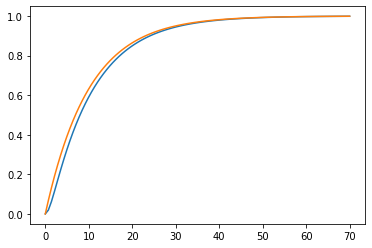

In [ ]:
plotstep(G1)
plotstep(G2)

First order systems in series often have step responses which resemble those of lower order systems with increasing dead time:

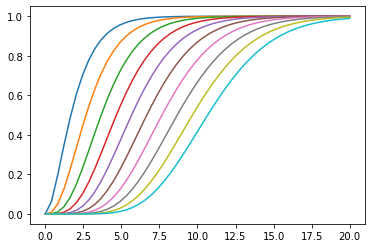

In [ ]:
ts = numpy.linspace(0, 20)
G = 1/(s + 1)
for i in range(10):
    G *= 1/(s + 1)
    plotstep(G, T=ts)

If we use the 0, 1 Padé approximation of dead time:

$$e^{-\theta s} \approx \frac{1}{1 + \theta s}$$

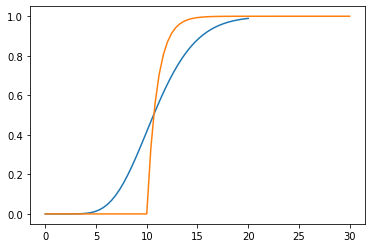

In [ ]:
plotstep(G, T=ts)
plotstep(1/(s + 1), D=10, T=ts)

We see that we get the same kind of behaviour but the dynamics start too fast and end too slow.

We can "eyeball" a lower-order response which matches the last 10th order response pretty well. Play with these sliders and see how easy it is to match the lines together.

In [ ]:
def approx(tau, D):
    plotstep(G, T=numpy.linspace(0, 30))
    plotstep(1/(tau*s + 1), D=D, T=numpy.linspace(0, 30 - D))
    plt.show()

In [ ]:
interact(approx, tau=(1., 10.), D=(1., 10.))

interactive(children=(FloatSlider(value=5.5, description='tau', max=10.0, min=1.0), FloatSlider(value=5.5, des…

<function __main__.approx(tau, D)>

## Skogestad's "Half Rule"

Skogestad's "half rule" is specifically designed to approximate complicated transfer functions as first order plus dead time (FOPDT) or second order plus dead time (SOPDT) models: 

$$ \text{FOPDT: } \frac{K e^{-\theta s}}{\tau s + 1} \qquad \text{SOPDT: } \frac{K e^{-\theta s}}{(\tau_1 s + 1)(\tau_2 s + 1)}$$

The method does not work for systems with complex roots or unstable systems.

The function `tbcontrol.numeric.skogestad_half` implements this method.

For instance, let's take the transfer function from Example 5.4:

$$G(s) = \frac{K(-0.1s + 1)}{(5s + 1)(3s + 1)(0.5s + 1)}$$

The gains are always matched, so we can safely use $K=1$

In [ ]:
K = 1

In [ ]:
G = K*(-0.1*s + 1)/((5*s + 1)*(3*s + 1)*(0.5*s + 1))

In [ ]:
from tbcontrol.numeric import skogestad_half

In [ ]:
θ1, [τ] = skogestad_half([-0.1], [5, 3, 0.5], delay=0, order=1)
Gapprox1 = K/(τ*s + 1)

In [ ]:
θ2, [τ1, τ2] = skogestad_half([-0.1], [5, 3, 0.5], delay=0, order=2)
Gapprox2 = K/((τ1*s + 1)*(τ2*s + 1))

Let's see what our final approximations look like:

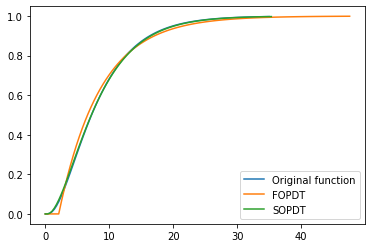

In [ ]:
plotstep(G)
plotstep(Gapprox1, D=θ1)
plotstep(Gapprox2, D=θ2)
plt.legend([
    'Original function',
    'FOPDT',
    'SOPDT'])

Not bad!